In [1]:
import os
import pretty_midi
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

In [2]:
# ===== Helpers to get MIDI files =====

def get_midi_files_from_folder(folder_path):
    midi_files = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.mid', '.midi')):
            midi_files.append(os.path.join(folder_path, file))
    return midi_files

# ===== Parse notes from right hand (track 0) only =====

def parse_rh_notes_pretty_midi(midi_file):
    """
    Extract notes only from first instrument (track 0) - assumed right hand.
    Returns list of (pitch, duration) tuples.
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    if len(pm.instruments) == 0:
        return []
    rh_instrument = pm.instruments[0]
    notes = []
    for note in rh_instrument.notes:
        duration = note.end - note.start
        notes.append((note.pitch, duration))
    return notes

# For model-generated samples, assume same parsing (right hand only)
parse_model_notes = parse_rh_notes_pretty_midi

# ===== Histogram computations =====

def get_pitch_histogram(notes, bins=range(21, 109)):
    pitches = [p for p, d in notes]
    hist, _ = np.histogram(pitches, bins=bins)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

def get_duration_histogram(notes, bins=None):
    durations = [d for p, d in notes]
    if bins is None:
        bins = np.linspace(0, 2.0, 20)  # durations up to 2 seconds
    hist, _ = np.histogram(durations, bins=bins)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

# ===== Aggregation for multiple files =====

def aggregate_notes_from_midis(midi_files, parser):
    all_notes = []
    for f in midi_files:
        try:
            notes = parser(f)
            all_notes.extend(notes)
        except Exception as e:
            print(f"Failed to parse {f}: {e}")
    return all_notes

# ===== Self-BLEU computation =====

def notes_to_pitch_sequence(notes):
    return [p for p, d in notes]

def self_bleu(generated_samples):
    """
    Compute average Self-BLEU for a list of generated samples (pitch sequences).
    """
    scores = []
    for i, hyp in enumerate(generated_samples):
        refs = [s for j, s in enumerate(generated_samples) if j != i]
        if len(refs) == 0:
            continue
        try:
            score = sentence_bleu(refs, hyp, weights=(0.5, 0.5))
            scores.append(score)
        except:
            # BLEU may fail if sequences are too short
            pass
    return np.mean(scores) if scores else 0.0

def get_pitch_sequences(midi_files, parser):
    sequences = []
    for f in midi_files:
        notes = parser(f)
        seq = notes_to_pitch_sequence(notes)
        if len(seq) > 0:
            sequences.append(seq)
    return sequences

# ===== Histogram plotting =====

def plot_histograms(hist1, hist2, label1='Model1', label2='Model2', title='Histogram comparison'):
    plt.figure(figsize=(10, 4))
    width = 0.4
    x = np.arange(len(hist1))
    plt.bar(x - width/2, hist1, width=width, label=label1)
    plt.bar(x + width/2, hist2, width=width, label=label2)
    plt.title(title)
    plt.xlabel('Bin Index')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()


In [8]:
def get_tempo_std(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    tempos, _ = pm.get_tempo_changes()
    if len(tempos) <= 1:
        return 0.0  # Only one tempo means perfectly consistent
    return np.std(tempos)

def aggregate_tempo_std(midi_files):
    tempo_stds = []
    for f in midi_files:
        try:
            std = get_tempo_std(f)
            tempo_stds.append(std)
        except Exception as e:
            print(f"Failed to process {f}: {e}")
    return np.mean(tempo_stds), np.std(tempo_stds)


def get_beat_std(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    beat_times = pm.get_beats()
    if len(beat_times) < 2:
        return 0.0
    beat_intervals = np.diff(beat_times)
    return np.std(beat_intervals)

def aggregate_beat_std(midi_files):
    beat_stds = []
    for f in midi_files:
        try:
            std = get_beat_std(f)
            beat_stds.append(std)
        except Exception as e:
            print(f"Failed to process {f}: {e}")
    return np.mean(beat_stds), np.std(beat_stds)


def get_tempo_std(midi_file):
    """
    Compute the standard deviation of tempo values in a MIDI file.
    Lower values indicate more consistent tempo.
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    tempos, _ = pm.get_tempo_changes()
    if len(tempos) <= 1:
        return 0.0  # One tempo = perfectly consistent
    return np.std(tempos)

def aggregate_tempo_stds(midi_files):
    """
    Compute mean and std of Tempo STD across multiple MIDI files.
    """
    tempo_stds = []
    for f in midi_files:
        try:
            std = get_tempo_std(f)
            tempo_stds.append(std)
        except Exception as e:
            print(f"Failed to process {f}: {e}")
    if not tempo_stds:
        return 0.0, 0.0
    return np.mean(tempo_stds), np.std(tempo_stds)


Define midis

In [4]:
train_folder = '../../data/'
model1_folder = 'markov_model/'
model2_folder = 'symbolic_unconditional/'


train_midis = get_midi_files_from_folder(train_folder)
markov_midis = get_midi_files_from_folder(model1_folder)
su_midis = get_midi_files_from_folder(model2_folder)

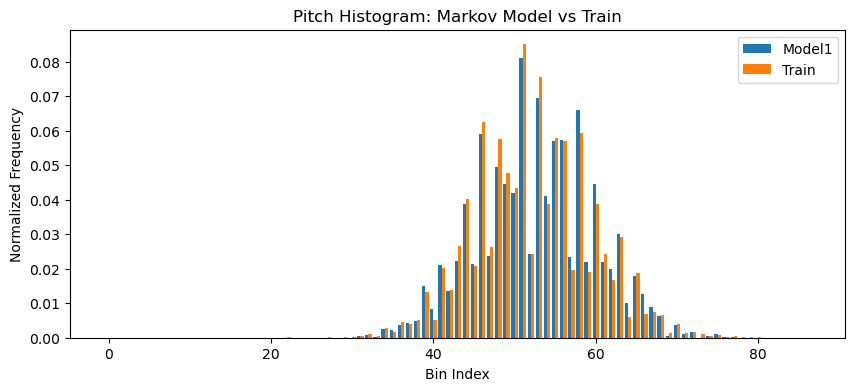

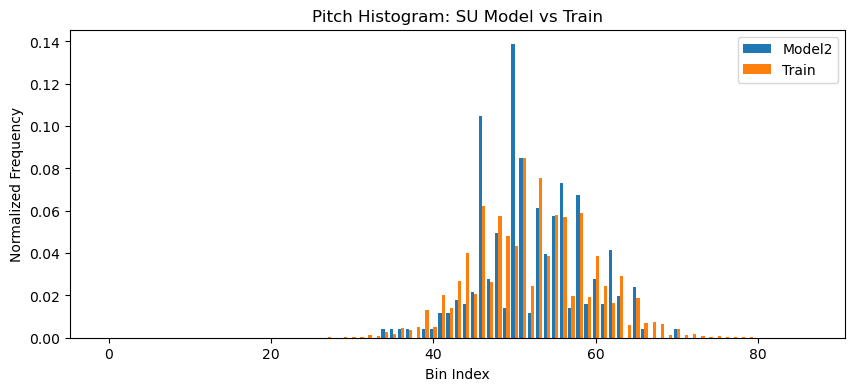

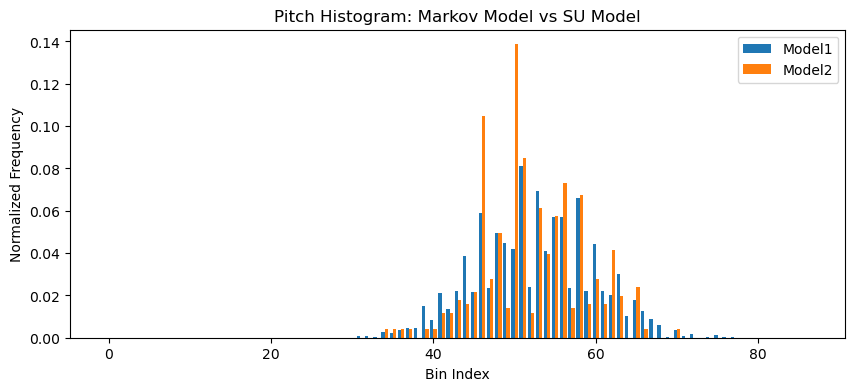

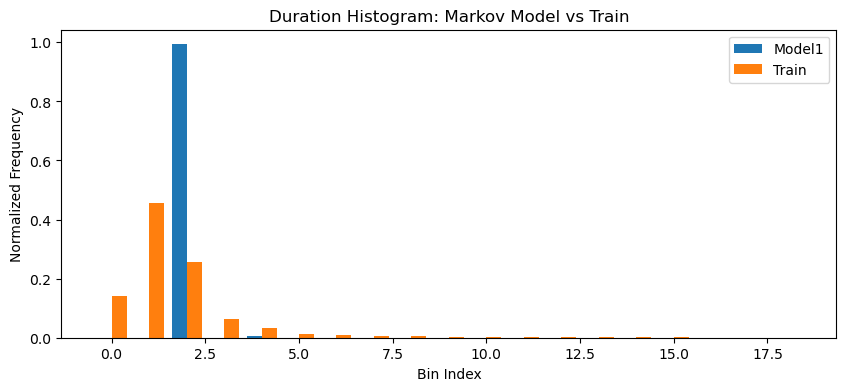

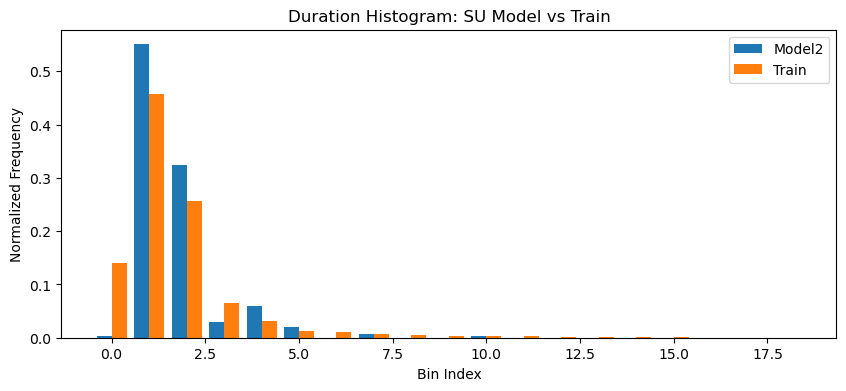

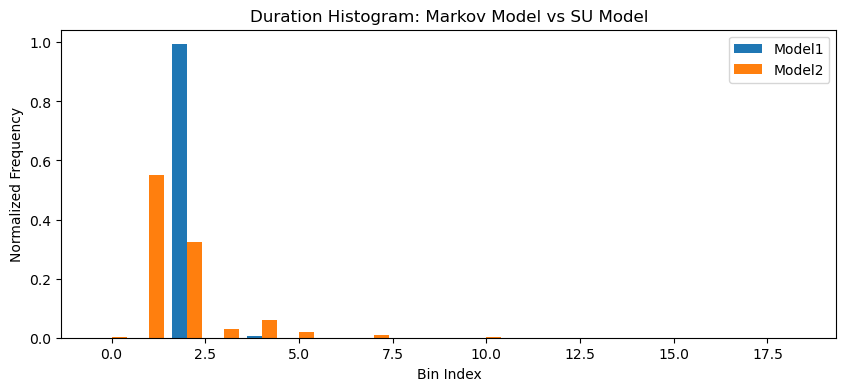

In [5]:
# Aggregate notes (only right hand for train, right hand assumed for models)
train_notes = aggregate_notes_from_midis(train_midis, parse_rh_notes_pretty_midi)
model1_notes = aggregate_notes_from_midis(markov_midis, parse_model_notes)
model2_notes = aggregate_notes_from_midis(su_midis, parse_model_notes)

# Compute histograms
pitch_bins = range(21, 109)
duration_bins = np.linspace(0, 2.0, 20)

train_pitch_hist = get_pitch_histogram(train_notes, bins=pitch_bins)
model1_pitch_hist = get_pitch_histogram(model1_notes, bins=pitch_bins)
model2_pitch_hist = get_pitch_histogram(model2_notes, bins=pitch_bins)

train_duration_hist = get_duration_histogram(train_notes, bins=duration_bins)
model1_duration_hist = get_duration_histogram(model1_notes, bins=duration_bins)
model2_duration_hist = get_duration_histogram(model2_notes, bins=duration_bins)


# Plot pitch histograms: model vs train
plot_histograms(model1_pitch_hist, train_pitch_hist, 'Model1', 'Train', 'Pitch Histogram: Markov Model vs Train')
plot_histograms(model2_pitch_hist, train_pitch_hist, 'Model2', 'Train', 'Pitch Histogram: SU Model vs Train')

# Plot pitch histograms: model1 vs model2
plot_histograms(model1_pitch_hist, model2_pitch_hist, 'Model1', 'Model2', 'Pitch Histogram: Markov Model vs SU Model')

# Plot duration histograms similarly
plot_histograms(model1_duration_hist, train_duration_hist, 'Model1', 'Train', 'Duration Histogram: Markov Model vs Train')
plot_histograms(model2_duration_hist, train_duration_hist, 'Model2', 'Train', 'Duration Histogram: SU Model vs Train')
plot_histograms(model1_duration_hist, model2_duration_hist, 'Model1', 'Model2', 'Duration Histogram: Markov Model vs SU Model')

# Compute Self-BLEU on pitch sequences
model1_sequences = get_pitch_sequences(markov_midis, parse_model_notes)
model2_sequences = get_pitch_sequences(su_midis, parse_model_notes)

model1_self_bleu = self_bleu(model1_sequences)
model2_self_bleu = self_bleu(model2_sequences)



In [9]:
train_beat_mean, train_beat_std = aggregate_beat_std(train_midis)
model1_beat_mean, model1_beat_std = aggregate_beat_std(markov_midis)
model2_beat_mean, model2_beat_std = aggregate_beat_std(su_midis)

print(f"Train Beat STD Mean: {train_beat_mean:.4f}")
print(f"Model1 Beat STD Mean: {model1_beat_mean:.4f}")
print(f"Model2 Beat STD Mean: {model2_beat_mean:.4f}")


print(f"Model1 Self-BLEU (diversity): {model1_self_bleu:.4f}")
print(f"Model2 Self-BLEU (diversity): {model2_self_bleu:.4f}")


train_tempo_mean, train_tempo_std = aggregate_tempo_stds(train_midis)
model1_tempo_mean, model1_tempo_std = aggregate_tempo_stds(markov_midis)
model2_tempo_mean, model2_tempo_std = aggregate_tempo_stds(su_midis)

print(f"Train Tempo STD Mean: {train_tempo_mean:.4f}")
print(f"Model1 Tempo STD Mean: {model1_tempo_mean:.4f}")
print(f"Model2 Tempo STD Mean: {model2_tempo_mean:.4f}")

Train Beat STD Mean: 0.0192
Model1 Beat STD Mean: 0.0000
Model2 Beat STD Mean: 0.0000
Model1 Self-BLEU (diversity): 0.9582
Model2 Self-BLEU (diversity): 0.4097
Train Tempo STD Mean: 44.4347
Model1 Tempo STD Mean: 0.0000
Model2 Tempo STD Mean: 0.0000


Lower values indicate more consistent beat spacing (i.e., steadier rhythm or tempo feel).



---

# Notes

# Single Model Output

Self-BLEU: diversity within generated samples


# Compare between training data

Pitch Histogram Distance: Compare pitch distributions (e.g., histogram difference, Earth Mover’s Distance).


Duration Histogram Distance: Compare note duration distributions.


# Compare between Models

Pitch Histogram Distance: Compare pitch distributions (e.g., histogram difference, Earth Mover’s Distance).


Duration Histogram Distance: Compare note duration distributions.
